In [2]:
import os
import pydicom
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy

In [3]:
SLICE_FOLDER = '../data/RadCTTACEomics_1685/1685/10_AP_Ax2.50mm/'

In [ ]:
# load dicom slice files
slices = [pydicom.dcmread(os.path.join(SLICE_FOLDER, f)) 
          for f in os.listdir(SLICE_FOLDER) if f.endswith('.dcm')]

# sort slices by SliceLocation (or InstanceNumber)
slices.sort(key=lambda x: int(x.SliceLocation))

# Stack into 3D volume
img_dcm = np.stack([s.pixel_array for s in slices], axis=0)

In [5]:
def median_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, :, img_dcm.shape[1]//2]

def median_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the median sagittal plane of the CT image provided. """
    return img_dcm[:, img_dcm.shape[2]//2, :]

In [6]:
def MIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the sagittal orientation. """
    return np.max(img_dcm, axis=2)

def MIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the maximum intensity projection on the coronal orientation. """
    return np.max(img_dcm, axis=1)

In [7]:
def AIP_sagittal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the sagittal orientation. """
    return np.mean(img_dcm, axis=2)

def AIP_coronal_plane(img_dcm: np.ndarray) -> np.ndarray:
    """ Compute the average intensity projection on the coronal orientation. """
    return np.mean(img_dcm, axis=1)

In [8]:
def rotate_on_axial_plane(img_dcm: np.ndarray, angle_in_degrees: float) -> np.ndarray:
    """ Rotate the image on the axial plane. """
    return scipy.ndimage.rotate(img_dcm, angle_in_degrees, axes=(1, 2), reshape=False)

In [9]:
slices[0].SliceThickness, slices[0].PixelSpacing

('5.00', [0.767578, 0.767578])

In [10]:
slices[0].PixelSpacing[0]

'0.767578'

In [11]:
[float(slices[0].SliceThickness), float(slices[0].PixelSpacing[0]), slices[0].PixelSpacing[1]]

[5.0, 0.767578, '0.767578']

In [12]:
slices[0]

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 174
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.840.113704.1.111.3956.1410855854.4865
(0002,0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002,0013) Implementation Version Name         SH: 'dcm4che-1.4-JP'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 192'
(0008,0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL', 'HELIX']
(0008,0012) Instance Creation Date              DA: ''
(0008,0013) Instance Creation Time              TM: '102414'
(0008,0016) SOP Class UID                       UI: CT Image Storage
(0008,0017) Acquisition UID                     UI: 1801

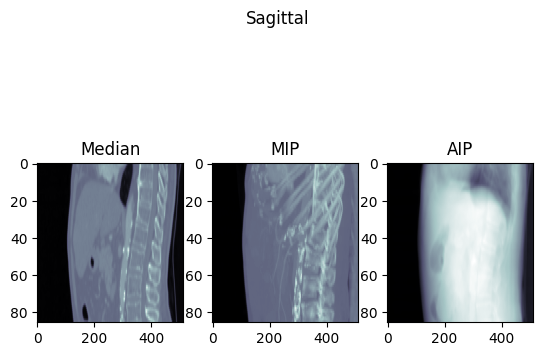

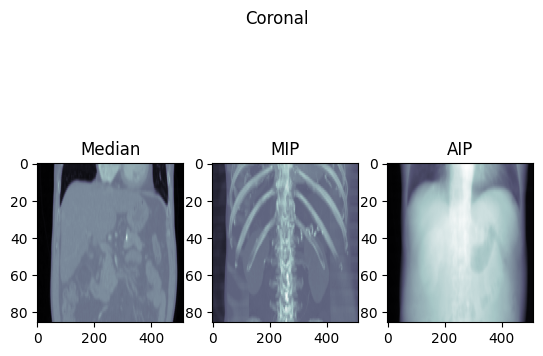

In [ ]:
pixel_len_mm = [5.0, 0.767578, 0.767578]

fig, ax = plt.subplots(1, 3)
ax[0].imshow(median_sagittal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0].set_title('Median')
ax[1].imshow(MIP_sagittal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1].set_title('MIP')
ax[2].imshow(AIP_sagittal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[2].set_title('AIP')
fig.suptitle('Sagittal')
plt.show()
fig, ax = plt.subplots(1, 3)
ax[0].imshow(median_coronal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[0].set_title('Median')
ax[1].imshow(MIP_coronal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[1].set_title('MIP')
ax[2].imshow(AIP_coronal_plane(img_dcm), cmap=matplotlib.colormaps['bone'], aspect=pixel_len_mm[0]/pixel_len_mm[1])
ax[2].set_title('AIP')
fig.suptitle('Coronal')
plt.show()

MovieWriter ffmpeg unavailable; using Pillow instead.


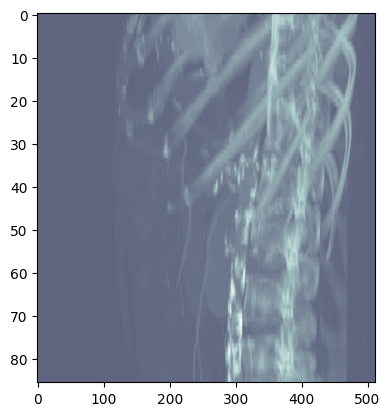

In [14]:
# Create projections varying the angle of rotation
#   Configure visualization colormap
img_min = np.amin(img_dcm)
img_max = np.amax(img_dcm)
cm = matplotlib.colormaps['bone']
fig, ax = plt.subplots()
#   Configure directory to save results
os.makedirs('results/MIP/', exist_ok=True)
#   Create projections
n = 24
projections = []
for idx, alpha in enumerate(np.linspace(0, 360*(n-1)/n, num=n)):
    rotated_img = rotate_on_axial_plane(img_dcm, alpha)
    rotated_mask = rotate_on_axial_plane(pydicom.dcmread('../data/RadCTTACEomics_1685/1685/10_AP_Ax2.50mm_ManualROI_Tumor.dcm').pixel_array, alpha)
    projection = MIP_sagittal_plane(rotated_img)
    mask_projection = MIP_sagittal_plane(rotated_mask)
    overlay = np.ma.masked_where(mask_projection == 0, mask_projection)
    plt.imshow(projection, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])
    plt.imshow(overlay, cmap='Reds', alpha=0.5, aspect=pixel_len_mm[0] / pixel_len_mm[1])
    plt.savefig(f'results/MIP/Projection_{idx}.png')      # Save animation
    projections.append(projection)  # Save for later animation
# Save and visualize animation
animation_data = [
    [plt.imshow(img, animated=True, cmap=cm, vmin=img_min, vmax=img_max, aspect=pixel_len_mm[0] / pixel_len_mm[1])]
    for img in projections
]
anim = animation.ArtistAnimation(fig, animation_data,
                            interval=250, blit=True)
anim.save('results/MIP/Animation.gif')  # Save animation
plt.show()                              # Show animation